# Left Ventricle Full Quantification (LVQuan18) Challenge MICCAI 2018


Accurate cardiac left ventricle (LV) quantification is among the most clinically important and most frequently demanded tasks for identification and diagnosis of cardiac diseases and is of great interest in the research community of medical image analysis.
To explain what the challenge is about in the context of machine learning, I use the approach explained here:
https://machinelearningmastery.com/how-to-define-your-machine-learning-problem/.

It involves answering three questions:

### Problem description

In one sentence, we want a system that will find some information about the Left Ventricle (LV) out of cardiac images
to diagnose some heart diseases.

Tom Mitchell’s definition of a machine learning problem requires the definition of Tasks,
Experience and Performance. These terms are defined for this problem as follows:

* Tasks: Compute LV indices of each slice of patient cardiac SAX MR images. These indices are:

    1. Areas of LV cavity and myocardium : $A_{1}$ and $A_{2}$ (see Fig.1(a))
    2. Dimensions of LV cavity: $D_{1}, D_{2}$ and $D_{3}$ (see Fig.1(b))
    3. Reginal Wall Thickness of myocardium: $RWT_{1}, ..., RWT_{6}$ (see Fig.1(c))
    4. Cardiac phase (when images are acquired): diastole (0) or systole(1) (see Fig.1(d))
   
   <figure>
  <img src="data/lvquan.jpg" width="600">
  <figcaption> <center> Figure 1. LV indices to find. Orange and green areas are respectively LV cavity and myocardium.
  </center> </figcaption>
</figure>
   
    
* Experiences: A set of 145 anonymized patient cardiac SAX MR images with all 4 indices for each slice.


* Performance: Mean Absolute Error (MAE) to assess the performance of the method for estimation of indices 1,2 and 3. For the last indice, the Error Rate of the misclassified cardiac phase is used. Their formulae are:


$ MAE_{indice} = \frac{\sum_{i=1}^{N} \lvert Pred^{indice}_{i}  -  GT^{indice}_{i} \rvert }{N} $

$ER_{phase} = \frac{\sum_{i=1}^{N} Cardinal(Pred^{phase}_{i} \neq GT^{phase}_{i}) }{N} $

### The dataset provided

A training dataset with processed SAX MR sequences of 145 subjects from clinical environment is used for model learning and validation.

For each subject, 20 frames are included for the whole cardiac cycle. All ground truth values of the above-mentioned LV indices are provided for every single frame. More details about the training dataset can be found in the document of the DIG-Cardiac dataset. 


A complete information of the challenge can be found at: https://lvquan18.github.io/

References: 

[1]: Figure 1 from https://lvquan18.github.io/2018/03/12/objective.html

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from fastai.conv_learner import *
from fastai.dataset import *

from pathlib import Path
import json
from PIL import ImageDraw, ImageFont
from matplotlib import patches, patheffects
%matplotlib inline
%reload_ext autoreload
%autoreload 2

PATH ='data/'

## Dataset exploration

The provided dataset is a matlab file (.mat). 

Thus we're going to use scipy.io which can open this kind of file in python.

In [2]:
import scipy.io as sio

data = sio.loadmat(PATH+'cardiac-dig.mat')
data.keys()


dict_keys(['__header__', '__version__', '__globals__', 'areas', 'dims', 'endo_LV', 'epi_LV', 'images_LV', 'lv_phase', 'pix_spa', 'ratio_resize_inverse', 'rwt'])

In [4]:
f'{data["images_LV"].shape}, 2900 / 20 frames =  {2900/20} patients'

'(80, 80, 2900), 2900 / 20 frames =  145.0 patients'

In [5]:
n_diastolic = np.sum(data["lv_phase"] == 0) // 20
n_systolic = np.sum(data["lv_phase"] == 1) // 20
print(f'Number of sequences in diastolic phase :  {n_diastolic}')
print(f'Number of sequences in systolic phase  :  {n_systolic}')
print(f'Total                                  : {n_diastolic + n_systolic}')


Number of sequences in diastolic phase :  84
Number of sequences in systolic phase  :  61
Total                                  : 145


### An analysis of the relation between LV cavity area and the phase

[0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0]
[0 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0]
[0 0 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
[1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 1]
[1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0]


Text(0,0.5,'Area of LV cavity')

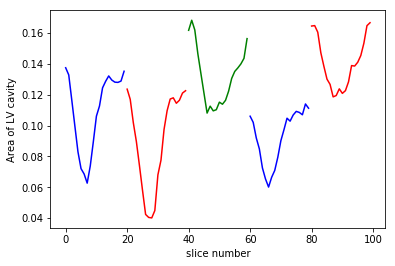

In [6]:
S = 20
k = 5
A = 0
for i in range(k):
    print(data['lv_phase'][0,i*S:(i+1)*S])
    
plt.plot(data['areas'][A,:S], 'b', range(S, 2*S), data['areas'][A,S:S+S], 'r',
        range(2*S, 3*S), data['areas'][A,2*S:3*S], 'g', 
        range(3*S, 4*S), data['areas'][A,3*S:4*S], 'b',
        range(4*S, 5*S), data['areas'][A,4*S:5*S], 'r')
plt.xlabel('slice number')
plt.ylabel('Area of LV cavity')

**Remark:**

It appears from the plot above that when the LV cavity area decreases, the phase is 1: Systole.

And, it equals 0 (diastole) when LV cavity increases. So one way to find the phase is to track
the LV cavity area

In [7]:
patient = data['images_LV'][:,:,:20]
seg_endo = data['endo_LV'][:,:,:20]
seg_epi = data['epi_LV'][:,:,:20]

def get_sample(seq, size=3):
    return np.hstack([seq[:,:,i] for i in range(size)])

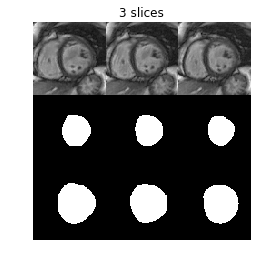

In [8]:
n = 3
slice_sample = get_sample(patient, n)
seg_endo_sample = get_sample(seg_endo, n)
seg_epi_sample = get_sample(seg_epi, n)
samples = np.vstack((slice_sample, seg_endo_sample, seg_epi_sample))
plt.imshow(samples, cmap='gray')
plt.title(f'{n} slices')
plt.axis("off")
plt.show()


In [9]:
print ('dims attribute', data['dims'].shape, data['dims'][:,0])
print ('areas attribute', data['areas'].shape, data['areas'][:,0])
print ('rwt attribute', data['rwt'].shape, data['rwt'][:,0])

dims attribute (3, 2900) [ 0.40795  0.4411   0.40617]
areas attribute (2, 2900) [ 0.13742  0.09059]
rwt attribute (6, 2900) [ 0.06005  0.04753  0.05253  0.05125  0.04902  0.06165]


# Our approach

We're going to directly predict LV indices from images without segmentation.

For that we use a classical model (e.g resnet50) for a regression task where the output
vector will contain all these values:
1. Areas: 2 values
2. Dimensions: 3 values
3. Reginal Wall Thickness: 6 values

Thus, an output vector of 11 values.

For the cardiac phase, we plan to use direct algorithm, no machine learning,
that will track LV area (A1) across slices and use the remark done above
to find the cardiac phase.


In [3]:
from fastai.conv_learner import *
from fastai.dataset import *

from pathlib import Path
import json
from PIL import ImageDraw, ImageFont
from matplotlib import patches, patheffects
# torch.cuda.set_device(3)

### Format input/output for CNN

Make one-channel input to 3 channel.
Arrange input/output axis for fastai.

(2900, 11)
(2900, 80, 80, 3)
(2900,)


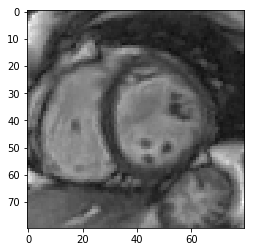

In [4]:
tmp_x = np.moveaxis(data['images_LV'], -1, 0)
x = np.empty((2900, 80, 80, 3))
for i in range(x.shape[0]):
    x[i] = np.stack((tmp_x[i],)*3, -1)

y = np.concatenate((data['areas'],data['dims'], data['rwt'])).T
lv_phase = np.moveaxis(data['lv_phase'], -1, 0).flatten()
print(y.shape)
print(x.shape)
print(lv_phase.shape)
plt.imshow(x[0])

In [5]:
def patientToImgIdx(patient_idxs):
    image_idxs = []
    for i in patient_idxs:
        image_idxs.append(np.arange(i*20, (i+1)*20))
    return np.concatenate(image_idxs)

def n_folds_split(samples, folds=3, seed=42):
  # reproducible results with a fixed seed
    rng = np.random.RandomState(seed)
    indices = samples if type(samples)is np.ndarray else np.arange(samples)
    rng.shuffle(indices)
    n_samples = indices.shape[0]
    spf, r = np.divmod(n_samples, folds)
    rr = [0]
    if r!= 0:
        rr += [i*(spf+1)for i in range(1, r+1)]
        rr += [i for i in range(rr[-1]+spf, n_samples+1, spf)]
    else: 
        rr += [i*spf for i in range(1, folds+1)]
    
    splits = [indices[rr[i]:rr[i+1]] for i in range(folds)]
    cv_splits = [(splits[i], np.concatenate([s for s in splits if s is not splits[i]])) for i in range(folds)]
    return cv_splits


 We use 110 cardiac MR for training and 35 for testing which is about 24.13 % of the dataset.
 
 The test set has been chosen randomly with 42 seed for reproducibility.

In [6]:
rng = np.random.RandomState(42)
idxs = np.arange(145)
rng.shuffle(idxs)
trn_idxs, test_idx = idxs[:110], idxs[110:]
folds = n_folds_split(trn_idxs, 5)

## Phase Identification

### A deterministic function

In [7]:
def comb_feats(lv_areas):
    res = np.copy(lv_areas)
    res[1:] = (res[1:] - lv_areas[:19])
    res[0] = res[1]
    return res

def phase_finder(lv_areas):
    res = comb_feats(lv_areas)
    res = (res<0.0).astype('float')
#     print(res)
    return res

In [8]:
def acc(pred, gt):
    res = (pred == gt).astype('int').mean()
    return res

areas = y[:, 0]
i = 0
areas.shape
acc(phase_finder(areas[i*20:(i+1)*20]), lv_phase[i*20:(i+1)*20])

0.80000000000000004

In [10]:
3*[1]

[1, 1, 1]

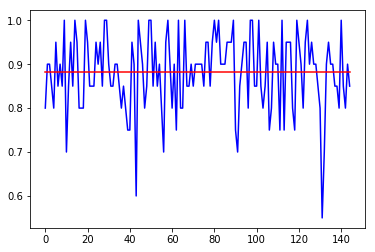

In [9]:
res_tot = []
for i in range(145):
    idxs = np.arange(i*20,(i+1)*20)
    res_tot.append(acc(phase_finder(areas[idxs]), lv_phase[idxs]))
m= np.mean(res_tot)
plt.plot(res_tot, 'b', 145*[m], 'r')


### With a Neural Network

In [10]:
from fastai.structured import *
from fastai.column_data import *
def PhaseNN():
    layers = nn.Sequential(
    nn.Linear(40, 50),
    nn.ReLU(),
    nn.BatchNorm1d(50),
    nn.Dropout(0.4),
    nn.Linear(50,40),
    nn.ReLU(),
    nn.BatchNorm1d(40),
    nn.Dropout(0.25),
    nn.Linear(40, 20),
    nn.LogSigmoid())
    return layers

def format_phase_data(phases):
    formatted = phases.reshape((-1, 20))
    new_feats = np.array(list(map(lambda x: comb_feats(x), formatted)))
    return np.concatenate((formatted, new_feats), axis=1)
    
def get_phase_data(arch, darray, split):
    formatted = format_phase_data(darray)
    tfms = tfms_from_model(arch, sz=1, crop_type=CropType.NO)
    trn, val, test = formatted
    data = ImageClassifierData.from_arrays(PATH, trn, val, bs, tfms, test=test,)
    return data
    pass
    

In [219]:
a = np.random.rand(2, 20)
b = format_phase_data(a)
b, b.shape
# b = np.array(list(map(lambda x: comb_feats(x), a)))
# np.concatenate((a, b), axis=1).shape

(array([[ 0.86985,  0.54967,  0.24442,  0.86129,  0.08788,  0.74451,  0.12061,  0.96422,  0.66253,  0.27793,
          0.06622,  0.65414,  0.18527,  0.68771,  0.06087,  0.97582,  0.61977,  0.07367,  0.77418,  0.411  ,
         -0.32019, -0.32019, -0.30525,  0.61687, -0.7734 ,  0.65663, -0.62391,  0.84362, -0.3017 , -0.3846 ,
         -0.21171,  0.58791, -0.46887,  0.50244, -0.62684,  0.91495, -0.35605, -0.5461 ,  0.70051, -0.36318],
        [ 0.78476,  0.85495,  0.49187,  0.28432,  0.62491,  0.32579,  0.11621,  0.57903,  0.19973,  0.96572,
          0.20425,  0.58753,  0.38704,  0.30519,  0.23958,  0.79693,  0.48547,  0.33877,  0.79342,  0.15397,
          0.07019,  0.07019, -0.36308, -0.20755,  0.34059, -0.29911, -0.20959,  0.46282, -0.3793 ,  0.76599,
         -0.76147,  0.38328, -0.20049, -0.08185, -0.06561,  0.55735, -0.31146, -0.1467 ,  0.45465, -0.63945]]),
 (2, 40))

## First fold of 5-CV folds

In [7]:
# trn, val, test
pval, ptrn = folds[0]
print(f'pval shape: {pval.shape}\ntrn: {ptrn.shape}')
val = patientToImgIdx(pval)
trn = patientToImgIdx(ptrn)
print(f'val shape: {val.shape}\ntrn: {trn.shape}')
dtrn = (x[trn], y[trn])
dval = (x[val], y[val])
# dtest = (x[test], y[test])
darray = (dtrn, dval, None)
phase_val = lv_phase[val]

pval shape: (22,)
trn: (88,)
val shape: (440,)
trn: (1760,)


In [8]:
transforms_top_down, transforms_side_on

([<fastai.transforms.RandomRotate at 0x7f160075bef0>,
  <fastai.transforms.RandomFlip at 0x7f160075bf98>])

In [9]:
custom_transform = transforms_basic + [RandomDihedral(), RandomFlip()]
def get_data(darray, arch, bs, aug=custom_transform):
    tfms = tfms_from_model(arch, sz=80, aug_tfms=aug, crop_type=CropType.NO)
    trn, val, test = darray
    data = ImageClassifierData.from_arrays(PATH, trn, val, bs, tfms, test=test, continuous=True)
    return data

arch = resnext50
bs=20
md = get_data(darray, arch, bs)
md.is_reg()


True

In [10]:
head_reg11 = nn.Sequential(
    Flatten(),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(18432, 1024),
    nn.ReLU(),
    nn.BatchNorm1d(1024),
    nn.Dropout(0.4),
    nn.Linear(1024,256),
    nn.ReLU(),
    nn.BatchNorm1d(256),
    nn.Dropout(0.25),
    nn.Linear(256, 11))
# head_reg11 = nn.Sequential(Flatten())
learner = ConvLearner.pretrained(arch, md, custom_head=head_reg11)
learner.opt_fn = optim.Adam
learner.crit = nn.L1Loss()

In [52]:
learner.summary()

OrderedDict([('Conv2d-1',
              OrderedDict([('input_shape', [-1, 3, 80, 80]),
                           ('output_shape', [-1, 64, 40, 40]),
                           ('trainable', False),
                           ('nb_params', 9408)])),
             ('BatchNorm2d-2',
              OrderedDict([('input_shape', [-1, 64, 40, 40]),
                           ('output_shape', [-1, 64, 40, 40]),
                           ('trainable', False),
                           ('nb_params', 128)])),
             ('ReLU-3',
              OrderedDict([('input_shape', [-1, 64, 40, 40]),
                           ('output_shape', [-1, 64, 40, 40]),
                           ('nb_params', 0)])),
             ('MaxPool2d-4',
              OrderedDict([('input_shape', [-1, 64, 40, 40]),
                           ('output_shape', [-1, 64, 20, 20]),
                           ('nb_params', 0)])),
             ('Conv2d-5',
              OrderedDict([('input_shape', [-1, 64, 20, 20]),
        

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 72%|███████▏  | 63/88 [00:04<00:01, 13.61it/s, loss=1.35] 


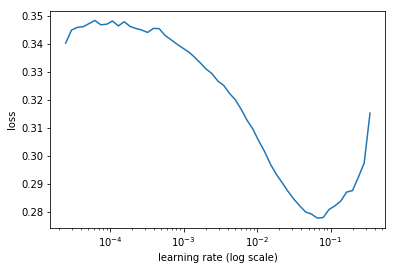

In [11]:
learner.lr_find(1e-5,100)
learner.sched.plot(5)

In [42]:
lr = 1e-2
lr

0.01

In [43]:
learner.fit(lr, 3, cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

epoch      trn_loss   val_loss                             
    0      0.100527   0.040885  
 19%|█▉        | 17/88 [00:01<00:04, 14.85it/s, loss=0.0938]

Exception in thread Thread-4:
Traceback (most recent call last):
  File "/home/ubuntu/src/anaconda3/envs/fastai/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/ubuntu/src/anaconda3/envs/fastai/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/ubuntu/src/anaconda3/envs/fastai/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



    1      0.054797   0.029018                              
    2      0.039223   0.027933                              



[array([ 0.02793])]

In [13]:
# learner.load('rnx50_cv1_ft_0.027')
learner.save('rnx50_cv1_ft_0.025')

In [45]:
predictions, target = learner.predict_with_targs()
i = 1
predictions[i], target[i]

(array([ 0.11596,  0.13843,  0.34964,  0.38135,  0.35855,  0.10552,  0.07655,  0.06015,  0.08393,  0.07962,
         0.09112], dtype=float32),
 array([ 0.14973,  0.1477 ,  0.39396,  0.46131,  0.45737,  0.11892,  0.0579 ,  0.0541 ,  0.07296,  0.08419,
         0.10173], dtype=float32))

In [46]:
i = 3
predictions[i], target[i], target.shape

(array([ 0.11487,  0.13977,  0.35145,  0.38764,  0.35958,  0.10313,  0.07876,  0.06317,  0.08795,  0.07976,
         0.08848], dtype=float32),
 array([ 0.11637,  0.16527,  0.3435 ,  0.41525,  0.39691,  0.13906,  0.07977,  0.07289,  0.08893,  0.09219,
         0.11905], dtype=float32),
 (440, 11))

In [47]:
learner.fit(lr, 2, cycle_len=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=4), HTML(value='')))

epoch      trn_loss   val_loss                              
    0      0.030261   0.025015  
    1      0.022537   0.02427                               
    2      0.02276    0.023812                              
    3      0.020462   0.032321                              



[array([ 0.03232])]

In [24]:
predictions, target = learner.predict_with_targs()

In [29]:
learner.load('rnx50_cv1_ft_0.023')

In [28]:
i = 2
predictions[i], target[i]

(array([ 0.13577,  0.11509,  0.39784,  0.42617,  0.40632,  0.08704,  0.06483,  0.0618 ,  0.06358,  0.05727,
         0.07556], dtype=float32),
 array([ 0.10824,  0.10371,  0.33833,  0.38451,  0.38869,  0.08352,  0.06874,  0.06747,  0.07309,  0.04978,
         0.06258], dtype=float32))

In [48]:
lrs = np.array([lr/100,lr/10,lr])
learner.freeze_to(-2)

In [49]:
learner.fit(lrs, 3, cycle_len=2, cycle_mult=2, best_save_name='rnx50_cv1')

HBox(children=(IntProgress(value=0, description='Epoch', max=14), HTML(value='')))

epoch      trn_loss   val_loss                              
    0      0.021006   0.019703  
    1      0.016804   0.016203                              
    2      0.018813   0.022527                              
    3      0.018264   0.016505                              
    4      0.015787   0.015726                              
    5      0.014075   0.014806                              
    6      0.017994   0.023716                              
    7      0.018025   0.022236                              
    8      0.017641   0.020127                              
    9      0.01621    0.017619                              
    10     0.015211   0.016378                              
    11     0.014159   0.016349                              
    12     0.013664   0.015047                              
    13     0.013048   0.014968                              



[array([ 0.01497])]

In [56]:
learner.load('rnx50_cv1_0.0148')
predictions, target = learner.predict_with_targs()

In [57]:
i = 11
predictions[i], target[i]

(array([ 0.12165,  0.12928,  0.38132,  0.40023,  0.39642,  0.0967 ,  0.0718 ,  0.07   ,  0.07229,  0.06926,
         0.09199], dtype=float32),
 array([ 0.13172,  0.1498 ,  0.3813 ,  0.4276 ,  0.41972,  0.11385,  0.05808,  0.0635 ,  0.07618,  0.08642,
         0.11889], dtype=float32))

In [44]:
learner.load('rnx50_cv1_lgp2_0.138')

In [59]:
# learner.freeze_to(-3)
# learner.fit(lrs, 5, cycle_len=2, cycle_mult=2, best_save_name='rnx50_cv1')

In [19]:
def logcosh_loss(input, target):
    loss = torch.mean(torch.log(torch.cosh(input - target)))
    # I looked at these quantities separately first then picked a multiplier
    #   to make them approximately equal
    return loss*100

def my_l1_loss(input, target):
    return F.l1_loss(V(input),V(target)).data

def mse_loss(input, target):
    return F.mse_loss(input, target)*100

learner.crit = logcosh_loss
learner.metrics = [my_l1_loss]


In [ ]:
learner.lr_find(1e-5,100)
learner.sched.plot(5)

In [18]:
lr=0.01
learner.fit(lr, 2, cycle_len=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=4), HTML(value='')))

epoch      trn_loss   val_loss   my_l1_loss                
    0      0.106814   0.016474   0.038045  
    1      0.02438    0.021552   0.034813                   
    2      0.013192   0.008186   0.030488                   
    3      0.008216   0.007187   0.02801                     



[array([ 0.00719]), 0.028010268568653952]

In [49]:
learner.load('rnx50_cv1')
predictions, target = learner.predict_with_targs()
F.l1_loss(Variable(torch.from_numpy(predictions)), Variable(torch.from_numpy(target))).data[0]

0.012532822787761688

## Custom loss: LogCosh loss

module

In [96]:
class LogCosh_Loss(torch.autograd.Function):

    def __init__(self):
        super(LogCosh_Loss, self).__init__()

    def forward(self,input, target):
        output = torch.log(torch.cosh(input - target))
        output = torch.sum(output)
        output = torch.Tensor([output]).cuda() # NEW line
#         input = torch.Tensor([input]).cuda()
        self.save_for_backward(input, output)
        return output
    


In [99]:
input = Variable(torch.rand(3))
target = Variable(torch.rand(3))
loss = torch.sum(torch.log(torch.cosh(input - target)))
LogCosh_Loss()(input, target)
(input - target).abs()

Variable containing:
 0.1066
 0.0327
 0.0619
[torch.FloatTensor of size 3]

In [117]:
input.data


 0.1104
 0.1924
 0.4644
[torch.FloatTensor of size 3]

In [118]:
input = Variable(torch.rand(3))
target = Variable(torch.rand(3))
save = True
res = torch.autograd.gradcheck(LogCosh_Loss(), (input, target), raise_exception=False)
print(res) # res should be True if the gradients are correct.

True


## Visualization of endocardium and epicardium

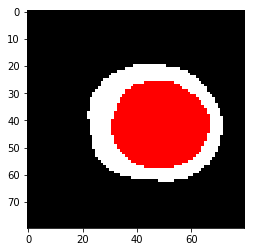

In [167]:
red  = (255, 0, 0) #np.array([255, 0, 0], dtype=np.uint8)
green = (0, 255, 0) #np.array([0, 255, 0], dtype=np.uint8)
blue   = (0, 0, 255) 
def overlay(im, mask, color):
    overlaid = im.copy()
    for i in range(im.shape[0]):
        for j in range(im.shape[1]):
            if (mask[i,j] > 100).all():
                overlaid[i,j] = color
    return overlaid

pat_endo = data['endo_LV'][:,:,200]
pat_endo = make_cv2_compatible(pat_endo)
pat_epi = data['epi_LV'][:,:,200]
pat_epi = make_cv2_compatible(pat_epi)
both = overlay(pat_epi, pat_endo, red)
plt.imshow(both)



## Compute Bounding Boxes of endocardium and epicardium segments

(80, 80, 3)
1
(22, 20, 50, 43)


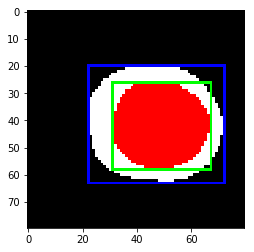

In [169]:
import cv2

def make_cv2_compatible(img, cmap='gray'):
    plt.imsave("tmp.jpg", img, cmap=cmap )
    im = cv2.imread('tmp.jpg')
    return im

def min_max(x):
    return np.min(x), np.max(x)


def meth1(pat):
    xs, ys = np.where(pat==1)
    min_x, max_x = min_max(xs)
    min_y, max_y = min_max(ys)
    # points = [[xs[i], ys[i]] for i in [min_x, max_x, min_y, max_y]]
    points = np.array([[min_y,min_x], [max_y,max_x]])
    return  cv2.boundingRect(points)
 
def get_bb(pat):
    im = make_cv2_compatible(pat)
    ctrs= cv2.findContours( cv2.cvtColor(im, cv2.COLOR_BGR2GRAY),cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE )[1]
    return cv2.boundingRect(ctrs[0])
    
pat = data['epi_LV'][:,:,200]




xs, ys = np.where(pat==1)

min_x, max_x = min_max(xs)
min_y, max_y = min_max(ys)
# points = [[xs[i], ys[i]] for i in [min_x, max_x, min_y, max_y]]
points = np.array([[min_y,min_x], [max_y,max_x]])
# seg_endo[:,:,0][22,39]
pat = make_cv2_compatible(pat)
print(pat.shape)
ctrs= cv2.findContours( cv2.cvtColor(pat, cv2.COLOR_BGR2GRAY),cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE )[1]
print(len(ctrs))
(x, y, w, h) = cv2.boundingRect(points)
print((x, y, w, h))
cv2.rectangle(both,(x, y), (x + w, y + h), (0, 0, 255), 1)
plt.imshow(both)

In [158]:
n = data["images_LV"].shape[-1]
print(data['endo_LV'].shape,n)
endo_bb = [meth1(data['endo_LV'][:,:,i]) for i in range(n)]
epi_bb = [meth1(data['epi_LV'][:,:,i]) for i in range(n)]

(80, 80, 2900) 2900
